In [1]:
! pip install scipy==1.7.3
! pip install seaborn==0.10.1
%env REPO_DIR=/Users/ben1/Library/CloudStorage/OneDrive-Personal/Documents/HARVARD/EC_985/hdi_downscaling_mosaiks/

In [2]:
import os

repo_dir = os.environ.get("REPO_DIR")
code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")

os.chdir(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import pickle
import sklearn
import sys
import pandas as pd
from importlib import reload

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import seaborn as sns

from mosaiks.utils.imports import *

# Key prediction functions are here
from analysis.prediction_utils import (X_matrix_to_demeaned_X, df_to_demeaned_y_vars,
                              get_within_perf_from_kfold_dict, cv_solve, solver_kwargs,
                            get_test_idxs)
                              
from analysis.prediction_utils import make_train_pred_scatterplot as make_scatterplot

env: REPO_DIR=/Users/ben1/Library/CloudStorage/OneDrive-Personal/Documents/HARVARD/EC_985/hdi_downscaling_mosaiks/


#  Demonstration -- simplified training of HDI model at ADM1 level

This is a greatly simplified version of the `analysis/hdi_and_iwi_model_training.ipynb` notebook.

In this notebook we train an ADM1 model to predict HDI. All data needed to run this demonstration is included in the GitHub repository.

To increase computational efficiency, we do not allow a different ridge hyperparameter on the MOSAIKS and NL features. This is different from what is presented in the primary analysis.

This notebook should run ~5 minutes on a standard laptop computer.

## Read in Xs and Ys -- and subset to training data set

### Read in MOSAIKS/RCF Xs

These daytime image feature files are included in the GitHub repository. They are also available at [mosaiks.org](mosaiks.org).

In [3]:
adm1_X = pd.read_pickle(
(data_dir + "features/mosaiks_features/"
"GDL_ADM1_polygon_X_creation_pop_weight=True.p")).drop(columns="GDLCODE")

adm1_X.head()

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_3990,X_3991,X_3992,X_3993,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999
GDLCODE,,,,,,,,,,,,,,,,,,,,,
AFGr101,0.296243,0.566399,0.132676,0.376191,0.423434,0.611262,0.104580,0.236502,0.300176,0.596828,...,0.352432,0.210764,0.604246,0.412964,0.256663,1.007759,1.779492,0.445359,0.605094,0.100552
AFGr102,0.205197,0.528473,0.034544,0.642563,0.322423,0.370223,0.046795,0.057652,0.595370,0.398343,...,0.110953,0.043917,0.170425,0.118251,0.105238,0.616474,0.700179,0.229152,0.464236,0.023037
AFGr103,0.178888,0.375205,0.067020,0.224368,0.260576,0.442619,0.085794,0.156746,0.173106,0.396240,...,0.202004,0.108165,0.392403,0.268643,0.158774,0.652044,1.217687,0.314744,0.400713,0.062426
AFGr104,0.231737,0.581338,0.050665,0.712425,0.370986,0.375820,0.049962,0.083120,0.663175,0.438051,...,0.122357,0.057889,0.219100,0.141557,0.102949,0.617183,0.799615,0.210456,0.434436,0.025360
AFGr105,0.185107,0.498972,0.036417,0.607406,0.300143,0.372042,0.055738,0.074171,0.561080,0.390058,...,0.112410,0.049431,0.194497,0.136292,0.107670,0.621367,0.713360,0.241749,0.480697,0.027199


### Read in Y variables

These `Y` variables (HDI + component indicators) were cleaned and saved in the `/code/analysis/hdi_label_creation.ipynb` notebook. It is not necessary to run this notebook, but we make replication code for data cleaning available.

In [4]:
raw = pd.read_pickle( (data_dir + "int/GDL_HDI/"
                     "HDI_indicators_and_indices_clean.p") ).loc[adm1_X.index]

raw.head()

,ISO_Code,country,year,level,region,continent,Sub-national HDI,Expected years schooling,Mean years schooling,Life expectancy,GNI per capita in thousands of US$ (2011 PPP),pop
GDLCODE,,,,,,,,,,,,
AFGr101,AFG,Afghanistan,2019,Subnat,Central (Kabul Wardak Kapisa Logar Parwan Panj...,Asia/Pacific,0.561,12.898,4.595,65.472,2615.157,
AFGr102,AFG,Afghanistan,2019,Subnat,Central Highlands (Bamyan Daikundi),Asia/Pacific,0.484,12.447,1.715,64.008,1572.594,
AFGr103,AFG,Afghanistan,2019,Subnat,East (Nangarhar Kunar Laghman Nooristan),Asia/Pacific,0.469,9.858,3.071,63.040,1550.047,
AFGr104,AFG,Afghanistan,2019,Subnat,North (Samangan Sar-e-Pul Balkh Jawzjan Faryab),Asia/Pacific,0.507,11.456,2.824,62.396,2491.727,
AFGr105,AFG,Afghanistan,2019,Subnat,North East (Baghlan Takhar Badakhshan Kunduz),Asia/Pacific,0.454,9.288,2.208,62.044,1802.716,


### Read in NL features

These NL features are included in the GitHub repo. They are based off the DMSP-OLS data product. Replication code for creating NL features for these administrative polygons is in the `code/analysis/NL_feature_creation_and_other_NL_processing/nighlight_pop_weighted_features_for_hdi_labels_DMSP.ipynb` notebook.

In [5]:
filepath = (data_dir + "features/nl_features/GDL_HDI_polygons/"
"dmsp_nightlight_features_for_hdi_polygons_20_bins_GPW_pop_weighted.p")
nl = pd.read_pickle(filepath).loc[adm1_X.index]

nl.head()

,perc_pixels_in_bin_0,perc_pixels_in_bin_1,perc_pixels_in_bin_2,perc_pixels_in_bin_3,perc_pixels_in_bin_4,perc_pixels_in_bin_5,perc_pixels_in_bin_6,perc_pixels_in_bin_7,perc_pixels_in_bin_8,perc_pixels_in_bin_9,perc_pixels_in_bin_10,perc_pixels_in_bin_11,perc_pixels_in_bin_12,perc_pixels_in_bin_13,perc_pixels_in_bin_14,perc_pixels_in_bin_15,perc_pixels_in_bin_16,perc_pixels_in_bin_17,perc_pixels_in_bin_18,perc_pixels_in_bin_19
GDLCODE,,,,,,,,,,,,,,,,,,,,
AFGr101,0.0,0.341528,0.097743,0.044700,0.023192,0.015027,0.019316,0.021764,0.013239,0.012001,0.019940,0.013452,0.018973,0.022304,0.014314,0.020570,0.030971,0.040767,0.063798,0.166403
AFGr102,0.0,0.998608,0.000806,0.000549,0.000037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AFGr103,0.0,0.867237,0.029551,0.018464,0.013235,0.007652,0.004762,0.004039,0.006819,0.002565,0.009129,0.005761,0.009349,0.006840,0.010498,0.004100,0.000000,0.000000,0.000000,0.000000
AFGr104,0.0,0.859081,0.022181,0.009918,0.004951,0.002039,0.000911,0.000853,0.000319,0.000441,0.000663,0.002035,0.000410,0.005102,0.004575,0.008858,0.013081,0.009298,0.012724,0.042560
AFGr105,0.0,0.947870,0.023249,0.010579,0.006459,0.002854,0.001993,0.003257,0.000800,0.000932,0.000670,0.000335,0.000586,0.000335,0.000084,0.000000,0.000000,0.000000,0.000000,0.000000


### Subset to training data

There is a held out set of test countries. The function `get_test_idxs()` will provide this test set.

In [6]:
train_idxs = raw["ISO_Code"][~raw["ISO_Code"].isin(get_test_idxs())].unique()

In [7]:
# Subset dense_df to training data
train_locs = raw["ISO_Code"].isin(train_idxs)


## Subset Y variables
train_df = raw.loc[train_locs].copy()

# Subset MOSAIKS Xs
train_locs = raw["ISO_Code"].isin(train_idxs)
X_train = adm1_X.loc[train_locs]

# Subset NL Xs
X_nl = nl.loc[train_df.index]

### Create demeaned feature sets

This demeaned Xs are needed for the within-country model.

In [8]:
X_demeaned = X_matrix_to_demeaned_X(X_train)
X_demeaned_nl = X_matrix_to_demeaned_X(X_nl)

### Set some basic solve parameters:

In [9]:
task = 'Sub-national HDI'


In [10]:
def get_idxs_without_adm0_observations(df, country_col = "ISO_Code"):
    """
    For country-demeaned outcomes, we want to remove all the ADM0 level observations. 
    
    In other words, if there is no within-country we shouldn't keep this as training data
    
    """
    col = task
    g = df.groupby("ISO_Code")
    
    country_counts = train_df.groupby(country_col)[col].count() 

    adm0_idxs = country_counts[country_counts == 1].index
    adm1_idxs = df.reset_index().set_index("ISO_Code").drop(adm0_idxs).set_index(df.index.name).index
    
    assert len(adm1_idxs) == len(df)-len(adm0_idxs)
    
    return adm1_idxs

# Begin running solves

###  RCF + NL features, cross country model

Sub-national HDI
Training model...

on fold (of 5): 0 1 2 3 4 



/opt/homebrew/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Sub-national HDI...


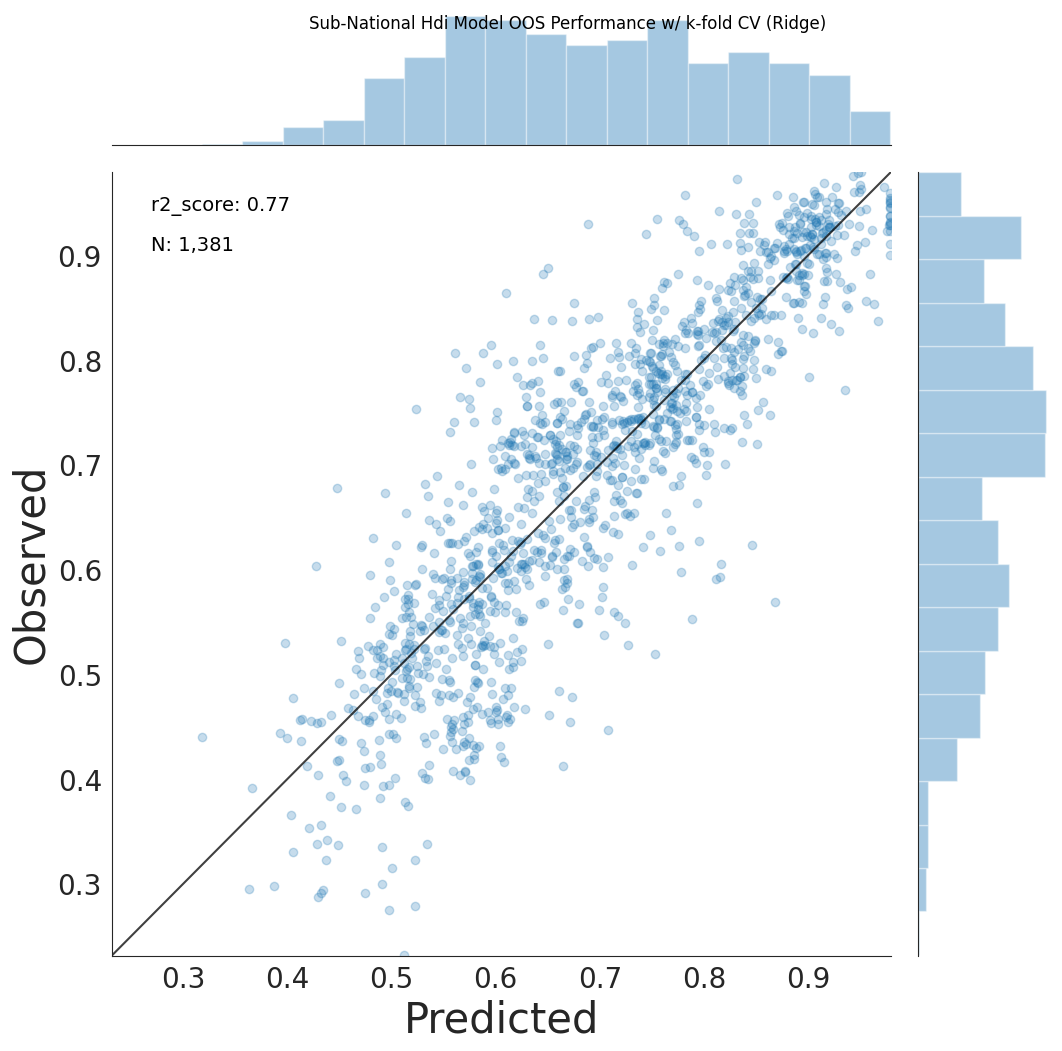

In [11]:
nl_and_rcf_kfold_dict = {}



Y_train = train_df[task]

nl_and_rcf_kfold_dict[task]  = cv_solve(task,
                                        pd.concat([X_train,X_nl],axis=1),# concatenate the rcf and nl data
                                        Y_train,
                                        clip_bounds = [np.min(Y_train), np.max(Y_train)],
                                        country_fold = True)

### RCF + NL Demeaned (Demeaned Ys and Demeaned Xs)

Zero obs dropped = 18
Sub-national HDI
Training model...

on fold (of 5): 0 1 2 3 4 



/opt/homebrew/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Plotting Sub-national HDI...


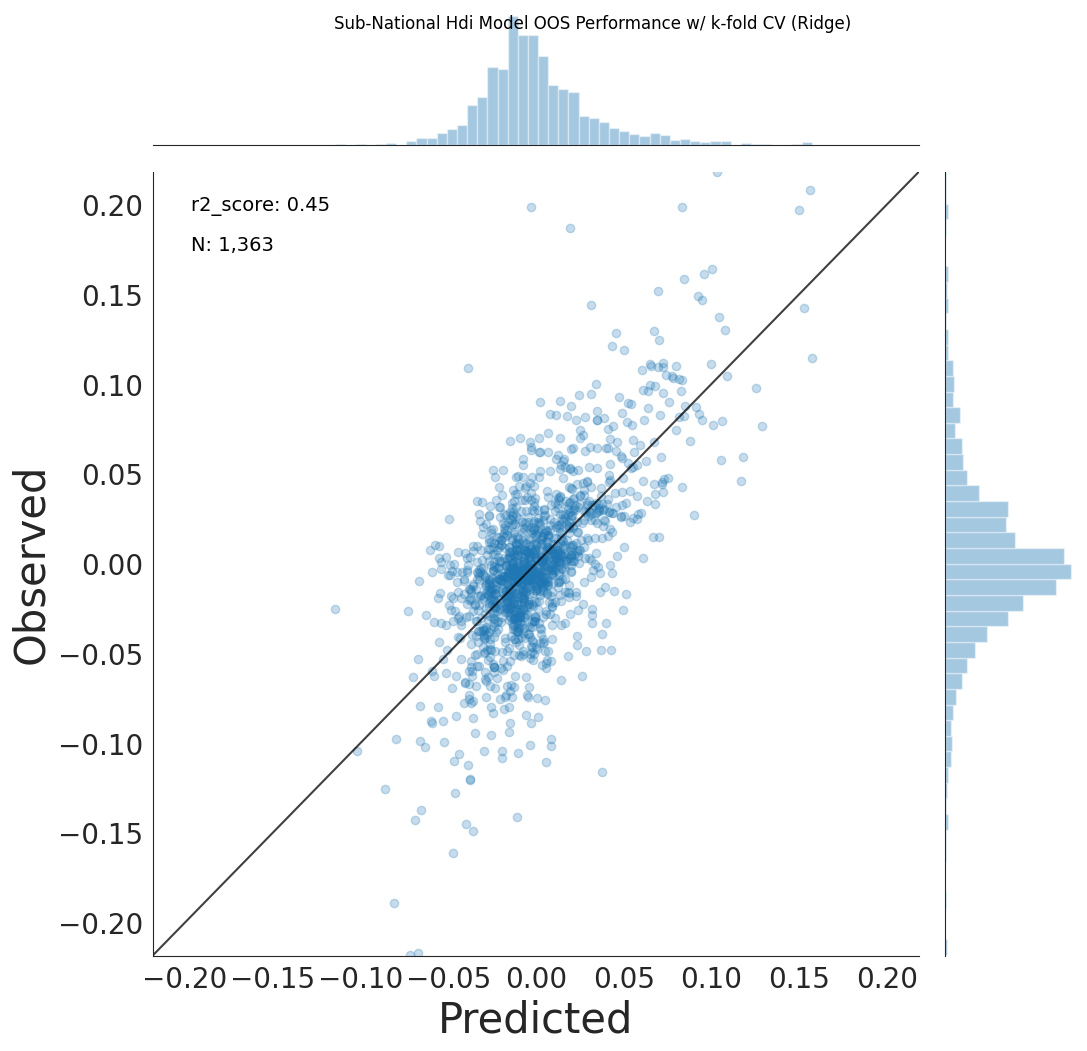

In [12]:
nl_and_rcf_demeaned_kfold_dict = {}


Y_demeaned = df_to_demeaned_y_vars(task, train_df)
    
##Let's drop Y observations that do not have any within country variation. There is nothing to learn from these:
keep_indxs = get_idxs_without_adm0_observations(train_df)
Y_demeaned = Y_demeaned.loc[keep_indxs]
X_demeaned_dropped = X_demeaned.loc[keep_indxs]
X2_demeaned_dropped = X_demeaned_nl.loc[keep_indxs]
    
print("Zero obs dropped =",(len(X_demeaned ) - len(X_demeaned_dropped)))
    
nl_and_rcf_demeaned_kfold_dict[task] = cv_solve(
    task,
    pd.concat([X_demeaned_dropped,X2_demeaned_dropped], axis=1), #concat the RCF and NL Xs
    Y_demeaned,
    clip_bounds = [np.min(Y_demeaned), np.max(Y_demeaned)],
     country_fold = True)